### ***Randomly loads images and masks***

Visualize different image-masks pairs to verify correctness

In [1]:
import random
import glob
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

OBJ_DETECT_ROOT = "/data/mkondrac/foundation_model_cardio/code/SAM/yolo_sam/dataset/object_detection"
OBJ_SEG_ROOT_YOLO = "/data/mkondrac/foundation_model_cardio/code/SAM/yolo_sam/dataset/object_segmentation/yolo_format"
OBJ_SEG_ROOT_SAM = "/data/mkondrac/foundation_model_cardio/code/SAM/yolo_sam/dataset/object_segmentation/sam_format"

In [2]:
import matplotlib.cm as cm

def get_color_for_class(cls_id):
    """Return a distinct RGB color for a given class id."""
    cmap = cm.get_cmap("tab10")  # 10 distinct colors
    r, g, b, _ = cmap(cls_id % 10)  # wrap around if > 10 classes
    return int(r * 255), int(g * 255), int(b * 255)

/tmp/ipykernel_1861419/1631067632.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab10")  # 10 distinct colors


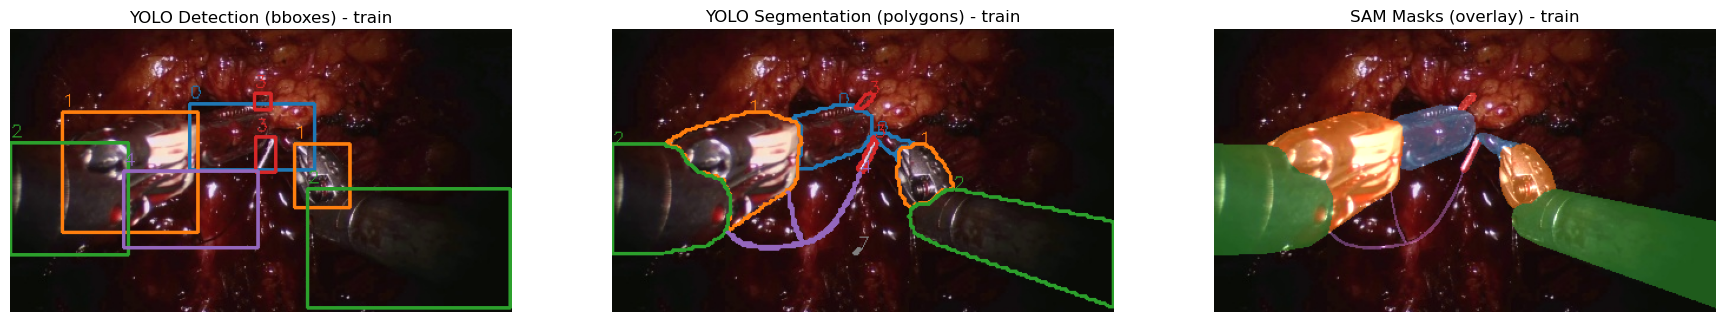

In [11]:
def show_random_yolo_detection_and_segmentation(split="train"):
    img_files = glob.glob(f"{OBJ_DETECT_ROOT}/images/{split}/*.jpg")
    if not img_files:
        print("No images found!")
        return

    img_file = random.choice(img_files)
    label_file_det = img_file.replace("/images/", "/labels/").replace(".jpg", ".txt")
    label_file_seg = img_file.replace(OBJ_DETECT_ROOT, OBJ_SEG_ROOT_YOLO).replace("/images/", "/labels/").replace(".jpg", ".txt")

    sam_img_folder = img_file.replace(OBJ_DETECT_ROOT, OBJ_SEG_ROOT_SAM).replace("/images/", f"/{split}/images/").rsplit("/", 1)[0]
    sam_label_folder = sam_img_folder.replace("/images/", "/labels/")

    # load base image
    img = cv2.imread(img_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_det = img.copy()
    img_seg = img.copy()
    img_sam = img.copy()
    h, w = img.shape[:2]

    # YOLO Detection (bboxes)
    if os.path.exists(label_file_det):
        with open(label_file_det) as f:
            for line in f:
                cls, x, y, bw, bh = map(float, line.split())
                x1 = int((x - bw / 2) * w)
                y1 = int((y - bh / 2) * h)
                x2 = int((x + bw / 2) * w)
                y2 = int((y + bh / 2) * h)

                color = get_color_for_class(int(cls))
                cv2.rectangle(img_det, (x1, y1), (x2, y2), color, 2)
                cv2.putText(img_det, str(int(cls)), (x1, y1 - 5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    # --- YOLO Segmentation (polygons) ---
    if os.path.exists(label_file_seg):
        with open(label_file_seg) as f:
            for line in f:
                parts = line.strip().split()
                cls = int(parts[0])
                coords = np.array(list(map(float, parts[1:]))).reshape(-1, 2)
                coords[:, 0] *= w
                coords[:, 1] *= h
                coords = coords.astype(np.int32)

                color = get_color_for_class(cls)
                cv2.polylines(img_seg, [coords], True, color, 2)
                cv2.putText(img_seg, str(cls), tuple(coords[0]),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    # SAM Masks (overlays)
    sam_label_root = os.path.join(OBJ_SEG_ROOT_SAM, split, "labels")
    sam_label_folder = os.path.join(sam_label_root, os.path.basename(img_file).replace(".jpg", ""))
    if os.path.exists(sam_label_folder):
        mask_files = glob.glob(f"{sam_label_folder}/**/*.png", recursive=True)
        for mask_file in mask_files:
            mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
            if mask is None or not mask.any():
                continue
            parent_folder = os.path.basename(os.path.dirname(mask_file))
            cls_id = int(parent_folder.split("_")[0])  # take number before "_" if exists
            color = get_color_for_class(cls_id)
            colored = np.zeros_like(img_sam)
            colored[mask > 0] = color
            img_sam = cv2.addWeighted(img_sam, 1.0, colored, 0.5, 0)

    # show side by side 
    fig, axs = plt.subplots(1, 3, figsize=(22, 15))
    axs[0].imshow(img_det)
    axs[0].set_title(f"YOLO Detection (bboxes) - {split}")
    axs[0].axis("off")

    axs[1].imshow(img_seg)
    axs[1].set_title(f"YOLO Segmentation (polygons) - {split}")
    axs[1].axis("off")

    axs[2].imshow(img_sam)
    axs[2].set_title(f"SAM Masks (overlay) - {split}")
    axs[2].axis("off")

    plt.show()


show_random_yolo_detection_and_segmentation("train")